In [1]:
import pandas as pd

path = "./archive/lemmetised_clean_data.csv"

# Charger uniquement les colonnes 'tags' et 'clean_text' du fichier CSV
df = pd.read_csv(path, usecols=['tags', 'clean_text'])

print(df.head())

                                                tags  \
0  ['Mental Health', 'Health', 'Psychology', 'Sci...   
1  ['Mental Health', 'Coronavirus', 'Science', 'P...   
2  ['Biotechnology', 'Neuroscience', 'Brain', 'We...   
3  ['Health', 'Neuroscience', 'Mental Health', 'P...   
4  ['Brain', 'Health', 'Development', 'Psychology...   

                                          clean_text  
0  photo josh riemer unsplash merry christmas hap...  
1  brain coronavirus guide curious troubling impa...  
2  mind nose smell training change brain six week...  
3  passionate synergy science technology provide ...  
4  youve heard havent phineas gage railroad worke...  


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from ast import literal_eval

# Prétraitement : Suppression des NaN et Transformation TF-IDF
tags = [
    "Blockchain", "Data Science", "Technology", "Programming", "Poetry",
    "Cryptocurrency", "Machine Learning", "Life", "Bitcoin", "Writing",
    "Politics", "Startup", "Life Lessons", "Self Improvement", "Covid 19",
    "Software Development", "Love", "Python", "Business", "Health",
    "Mental Health", "JavaScript", "Relationships", "Education",
    "Artificial Intelligence", "Culture", "Design", "Self", "Marketing",
    "Entrepreneurship", "Ethereum", "Music", "Productivity",
    "Web Development", "History", "Humor", "Data Visualization",
    "Leadership", "Social Media", "Psychology", "Travel", "Fiction",
    "Creativity", "Coronavirus", "Parenting", "Crypto", "Science",
    "Tech", "UX", "Short Story"
]

# Liste des 20 premiers tags
top_20_tags = tags[:20].copy()

#On ne garde que les article qui possent un des 20 tags séléctionnés

df['tags'] = df['tags'].apply(lambda x: literal_eval(x) if isinstance(x, str) else x)

# Filtrer le DataFrame pour ne garder que les articles avec ces tags
df = df[df['tags'].apply(lambda tags: any(tag in top_20_tags for tag in tags))].copy()

# On ne garde que le premier tag pour chaque article
df['main_tag'] = df['tags'].apply(lambda tags: next((tag for tag in tags if tag in top_20_tags), None))

# Supprime les lignes avec clean_text vide
df = df.dropna(subset=['clean_text'])

df_count = len(df)

# Initialisation du TfidfVectorizer sans IDF et sans normalisation pour capturer les fréquences brutes
vectorizer = TfidfVectorizer(use_idf=False, norm=None)

# Transformation des textes en matrice TF
X_tfidf = vectorizer.fit_transform(df['clean_text'])

# Obtenir les mots du vocabulaire et leurs occurrences totales
vocab = vectorizer.get_feature_names_out()
word_frequencies = np.array(X_tfidf.sum(axis=0)).flatten()

# Créer un DataFrame avec les fréquences
word_freq_df = pd.DataFrame({'word': vocab, 'frequency': word_frequencies})

# Trier par ordre décroissant
word_freq_df = word_freq_df.sort_values(by='frequency', ascending=False)

print(word_freq_df)

                                      word  frequency
348002                                 one   178830.0
99230                                 data   169966.0
488823                                time   168534.0
283507                                like   140445.0
366244                              people   124612.0
...                                    ...        ...
229619     httpswwwlinkedincominamiramraie        1.0
229617    httpswwwlinkedincominalextinsman        1.0
229616   httpswwwlinkedincominalexkalachyk        1.0
229614  httpswwwlinkedincominalainchabrier        1.0
548208          zzzzzzzzzzzzzzzzzzzzzzzzzz        1.0

[548209 rows x 2 columns]


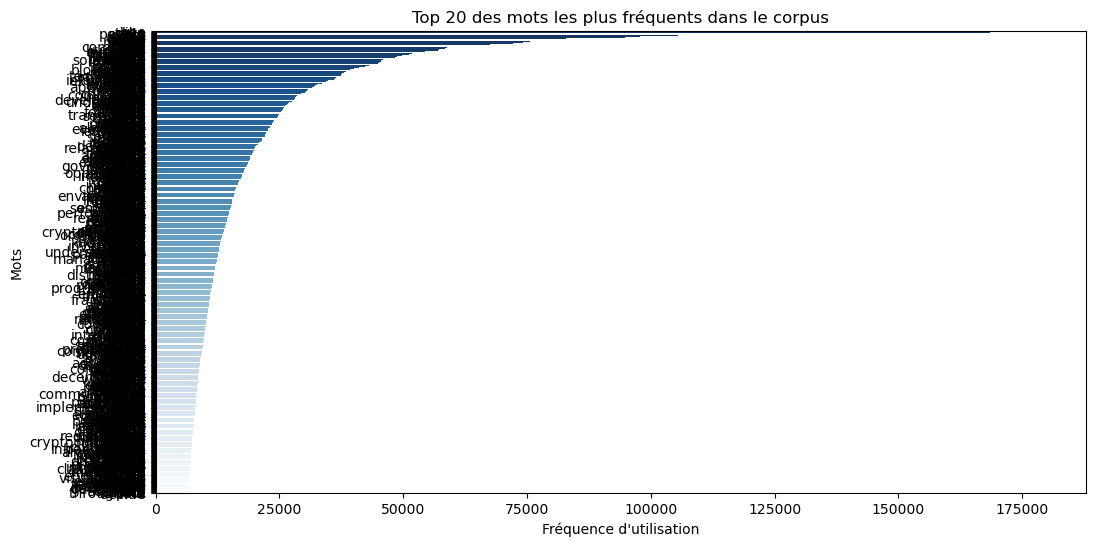

In [3]:
# 🔹 Tracer le graphique en barres
top_words = word_freq_df.head(1000)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_words['frequency'], y=top_words['word'], palette="Blues_r")

plt.xlabel("Fréquence d'utilisation")
plt.ylabel("Mots")
plt.title("Top 20 des mots les plus fréquents dans le corpus")
plt.show()

In [4]:
cumulative_freq = word_freq_df['frequency'].cumsum()
total_freq = cumulative_freq.iloc[-1]  # Fréquence totale de tous les mots

# Trouver le nombre de mots couvrant 95% du corpus
num_words_95 = (cumulative_freq <= total_freq * 0.95).sum()
num_words_99 = (cumulative_freq <= total_freq * 0.99).sum()

print(f"Nombre de mots nécessaires pour couvrir 95% du corpus : {num_words_95}")

print(f"Nombre de mots nécessaires pour couvrir 99% du corpus : {num_words_99}")


Nombre de mots nécessaires pour couvrir 95% du corpus : 25628
Nombre de mots nécessaires pour couvrir 99% du corpus : 225409


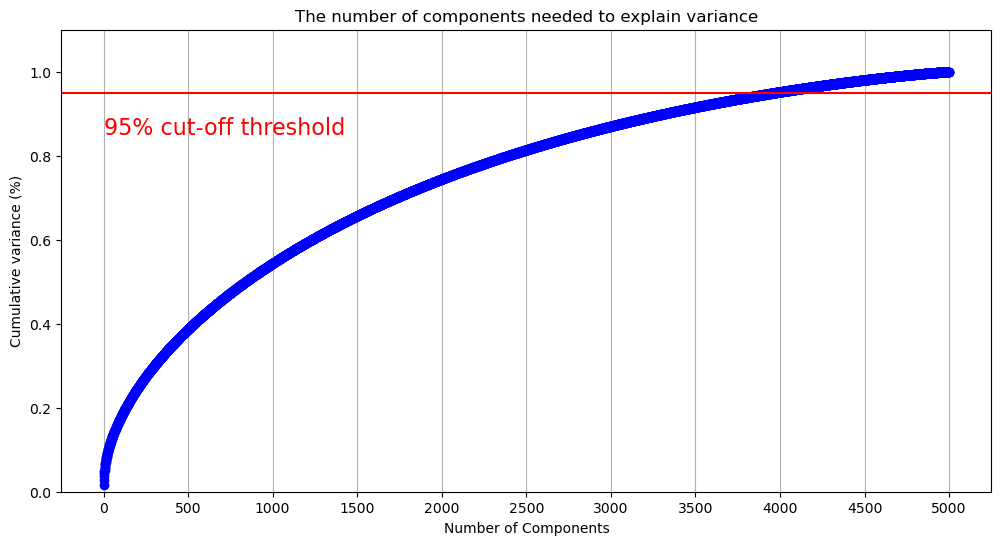

In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MaxAbsScaler

# 2. Transformation du texte en matrice TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Limiter le nombre de caractéristiques pour éviter la dimensionnalité élevée
X_tfidf = vectorizer.fit_transform(df['clean_text'])

# Scale the data to the range between 0 and 1
scaler = MaxAbsScaler()
data_rescaled = scaler.fit_transform(X_tfidf)

# Convertir la matrice sparse en matrice dense
data_rescaled_dense = data_rescaled.astype(np.float32).toarray()

# Appliquer PCA sur la matrice dense
pca = PCA()
pca.fit(data_rescaled_dense)


# Tracer la variance expliquée cumulée
plt.rcParams["figure.figsize"] = (12, 6)

fig, ax = plt.subplots()

# Créer xi en fonction du nombre réel de composants PCA
xi = np.arange(1, pca.n_components_ + 1)

# Cumul des variances expliquées
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0, 1.1)

# Tracer la courbe
plt.plot(xi, y, marker='o', linestyle='--', color='b')

# Ajouter la ligne seuil de 95%
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, "95% cut-off threshold", color='red', fontsize=16)

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, pca.n_components_ + 1, step=500))  # Ajuster le nombre de ticks pour correspondre au nombre de composants
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

ax.grid(axis='x')
plt.show()

# 6. Sauvegarder le DataFrame résultant dans un nouveau fichier CSV
# result_df.to_csv('./archive/pca_dataset.csv', index=False)

# Afficher un aperçu du nouveau DataFrame
# print(result_df.head())


In [6]:
# Calculer la variance expliquée par chaque composant
explained_variance = pca.explained_variance_ratio_

# Tracer la variance expliquée cumulée
cumulative_variance = explained_variance.cumsum()

# Trouver le nombre de composants qui expliquent 95% de la variance

optimal_components_95 = next(i for i, v in enumerate(cumulative_variance) if v >= 0.95)

print(f"Nombre de composants pour 95% de variance expliquée : {optimal_components_95 + 1}")

Nombre de composants pour 95% de variance expliquée : 3970


In [7]:
# Appliquer PCA avec le nombre optimal de composants
pca_optimal = PCA(n_components=19)  # +1 car indexé à partir de 0
X_pca = pca_optimal.fit_transform(data_rescaled_dense)

# 3. Créer un DataFrame avec les résultats de PCA
# Nous allons combiner les 50 composants dans une seule colonne sous forme de vecteur
df['PCA_text'] = [list(x) for x in X_pca]

# 4. Sélectionner les colonnes 'tags', 'clean_text' et 'PCA_text'
result_df = df[['tags', 'clean_text', 'PCA_text']]

# Afficher un aperçu du nouveau DataFrame
print(result_df.head())

                                                tags  \
0  [Mental Health, Health, Psychology, Science, N...   
3  [Health, Neuroscience, Mental Health, Psycholo...   
4  [Brain, Health, Development, Psychology, Science]   
5  [Society, Mental Health, Health, Nonfiction, C...   
6  [Books, Entrepreneurship, Writing, Marketing, ...   

                                          clean_text  \
0  photo josh riemer unsplash merry christmas hap...   
3  passionate synergy science technology provide ...   
4  youve heard havent phineas gage railroad worke...   
5  mentally young adult suffering covid come pain...   
6  turn popular blog series bestselling book thou...   

                                            PCA_text  
0  [0.39516538, 0.05899624, -0.021453878, -0.0111...  
3  [-0.21116884, 0.016064316, -0.0991472, 0.06884...  
4  [0.06188646, 0.008638164, -0.09875353, -0.0459...  
5  [0.1473181, -0.025129355, 0.022041861, 0.13384...  
6  [0.41400912, 0.13391365, 0.16083375, -0.136855..

In [8]:
# 5. Sauvegarder le DataFrame résultant dans un nouveau fichier CSV
result_df.to_csv('./archive/pca_data.csv', index=False)